# 🚀 Introduction

## ℹ️ Informations

- Lien du [jeu de données](https://www.kaggle.com/datasets/ektanegi/spotifydata-19212020).

## 📚 Importation des librairies

In [24]:
import numpy as np              # Pour les vecteurs et les matrices
import matplotlib.pyplot as plt # Pour les graphiques
import pandas as pd             
import sklearn as sk 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# - Spotify
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
# - Standard
from enum import Enum
import os
import re                       # Expression régulière
import math

from scipy import stats


## 📥 Importation des données

In [25]:
acousticness = 0
artists = 1
danceability = 2
duration_ms = 3
energy = 4
explicit = 5
identifier = 6
instrumentalness = 7
key = 8
liveness = 9
loudness = 10
mode = 11 
name = 12
popularity = 13
release_date = 14
speechiness = 15
tempo = 16
valence = 17
year = 18

Data = np.array(pd.read_csv("data.csv", header=None))

print(f"Le jeu de donnée contient {Data.shape[1]} variables pour {Data.shape[0]} observations")

Le jeu de donnée contient 19 variables pour 169909 observations


| Index | Nom | Type | Exemple | Description |
| -- | --- | --- | --- | --- |
| 0 | `acousticness` | Quantitative continue | | Une mesure de confiance de 0,0 à 1,0 pour déterminer si la piste est acoustique, c'est à dire quelle ne contient pas d'instruments de musiques électroniques. 1,0 représente une confiance élevée dans le fait que la piste est acoustique. |
| 1 | `artists` | tableau de chaînes de caractères | `["Michael Jackson", "Paul McCartney"]`  | Tableau contenant tous les artistes. |
| 2 | `Y` | Quantitative continue | `0.56` | L'aptitude à la danse décrit dans quelle mesure un morceau se prête à la danse. Une valeur de 0,0 est la moins dansante et une valeur de 1,0 est la plus dansante. |
| 3 | `duration_ms` | Quantitative ponctuelle | `240000` pour une musique de 240 secondes (4 minutes)  | La durée de la piste en millisecondes. |
| 4 | `energy` | Quantitative continue | `0.84` | L'énergie est une mesure comprise entre 0,0 et 1,0 et représente une mesure perceptuelle de l'intensité et de l'activité. En règle générale, les morceaux énergiques sont rapides, forts et bruyants. Par exemple, le death metal a une énergie élevée, tandis qu'un prélude de Bach obtient un score faible sur l'échelle. Les caractéristiques perceptives contribuant à cet attribut comprennent la gamme dynamique, l'intensité sonore perçue, le timbre, la vitesse d'apparition et l'entropie générale.|
| 5 | `explicit` | booléen | `True` une musique explicite | Indique si la musique est explicite (destinée à un public adulte) ou non. |
| 6 | `id` | chaîne de caractères |  | Identifiant spotify de la musique. |
| 7 | `instrumentalness` | Quantitative continue | | Détermine si une piste ne contient pas de voix. Les sons "Ooh" et "aah" sont considérés comme instrumentaux dans ce contexte. Les morceaux de rap ou de musique parlée sont clairement "vocaux". Plus la valeur de l'instrumentalité est proche de 1,0, plus il est probable que la piste ne contienne pas de contenu vocal. Les valeurs supérieures à 0,5 sont censées représenter des pistes instrumentales, mais la confiance est d'autant plus grande que la valeur s'approche de 1,0. |
| 8 | `key` | Qualitative | `3` pour Ré# | La tonalité de la piste. Les nombres entiers correspondent aux hauteurs en utilisant la notation standard de la classe de hauteur. Si aucune clé n'a été détectée, la valeur est -1. |
| 9 | `liveness` | Quantitative continue | `0.9` | Détecte la présence d'un public dans l'enregistrement. Des valeurs de vivacité plus élevées représentent une probabilité accrue que la piste ait été jouée en direct. Une valeur supérieure à 0,8 indique une forte probabilité que la piste soit en direct. |
| 10 | `loudness` | Quantitative continue | | L'intensité sonore globale d'une piste en décibels (dB). Les valeurs d'intensité sonore sont calculées en moyenne sur l'ensemble de la piste et sont utiles pour comparer l'intensité sonore relative des pistes. L'intensité sonore est la qualité d'un son qui est le principal corrélat psychologique de la force physique (amplitude). Les valeurs se situent généralement entre -60 et 0 db.|
| 11 | `mode` | Quantitative ponctuelle | `True` pour une musique en gamme majeure. | Mode indique la modulation (majeure ou mineure) d'une piste. Une piste modulée dans la gamme mineure sonne plus sombre que celle modulée dans la gamme majeure. |
| 12 | `name` | chaîne de caractères | `"S&M"`| Nom du titre. |
| 13 | `popularity` | Quantitative ponctuelle | |
| 14 | `release_date` | chaîne de caractères | `2003-04-15` | Date de sortie de la musique au format `AAAA-MM-JJ`. |
| 15 | `speechiness` | Quantitative continue | | Représente la présence de mots parlés dans une piste. Plus l'enregistrement est exclusivement vocal (par exemple, talk-show, livre audio, poésie), plus la valeur de l'attribut est proche de 1,0. Les valeurs supérieures à 0,66 décrivent des pistes qui sont probablement composées exclusivement de paroles. Les valeurs comprises entre 0,33 et 0,66 décrivent des pistes qui peuvent contenir à la fois de la musique et de la parole, soit en sections, soit en couches, y compris des cas tels que la musique rap. Les valeurs inférieures à 0,33 représentent très probablement de la musique et d'autres pistes ne ressemblant pas à de la parole. |
| 16 | `tempo` | Quantitative continue | | Le tempo global estimé d'une piste en battements par minute (BPM). Dans la terminologie musicale, le tempo est la vitesse ou le rythme d'un morceau donné et découle directement de la durée moyenne des battements. |
| 17 | `valence` | Quantitative continue | | Une mesure de 0,0 à 1,0 décrivant la positivité musicale transmise par une piste. Les morceaux ayant une valence élevée sonnent plus positivement (par exemple, heureux, gai, euphorique), tandis que les morceaux ayant une valence faible sonnent plus négativement (par exemple, triste, déprimé, en colère). |
| 18 | `year` | Quantitative ponctuelle | `2021` | L'année de sortie de la piste. |

## Préparation des données

1. On définit tout dabord une classe qui nous permettra de manipuler les données plus simplement.

In [27]:
class Data_Class():
    def __init__(self, X, Labels, Already_Scaled=False):
        self._Raw = X
        if not Already_Scaled:
            self._Scaled = (self._Raw - self.Mean()) / self.Standard_Deviation()
        else:
            self._Scaled = X
        self._Labels = Labels

    def Labels(self):
        return self._Labels

    def Raw(self):
        return self._Raw

    def Variables(self):
        try:
            return self._Raw.shape[1]
        except:
            return 1

    def Observations(self):
        return self._Raw.shape[0]

    def Scaled(self):
        return self._Scaled

    def Mean(self):
        return np.mean(self._Raw, axis=0)

    def Standard_Deviation(self):
        return np.std(self._Raw, axis=0)

Afin de déterminer la dansabilité d'une musique par rapport à ses caractéristiques, nous allons donc effectuer des analyses des variables suivantes en fonction de la variable `Y`.

- 

Dans notre analyse nous ignorons totalement les variables suivantes

- `release_date` : car elle est redondante avec l'année de sortie (`year`) de la musique.
- `id` : cela n'a pas d'intérêt pour l'analyse.

In [28]:
X_Raw_Temporary =    np.array([ Data[:,acousticness], 
                                Data[:,energy], 
                                Data[:,instrumentalness],
                                Data[:,liveness], 
                                Data[:,loudness], 
                                Data[:,mode],
                                Data[:,popularity],
                                Data[:,speechiness],
                                Data[:,tempo],
                                Data[:,valence],
                                Data[:,duration_ms], 
                                Data[:,year],
                                np.zeros(Data.shape[0]),    # C
                                np.zeros(Data.shape[0]),    # C#
                                np.zeros(Data.shape[0]),    # D
                                np.zeros(Data.shape[0]),    # D#
                                np.zeros(Data.shape[0]),    # E
                                np.zeros(Data.shape[0]),    # F
                                np.zeros(Data.shape[0]),    # F#
                                np.zeros(Data.shape[0]),    # G
                                np.zeros(Data.shape[0]),    # G#
                                np.zeros(Data.shape[0]),    # A
                                np.zeros(Data.shape[0]),    # A#
                                np.zeros(Data.shape[0])    # B
                                ], dtype=np.float64).T

# - Convertir les variables qualitatives en variables quantitatives
for i in range(Data.shape[0]):
    X_Raw_Temporary[i][Data[i][key] + 12] = 1.0
    #X[i][5] = (10 ** X[i][5]) / 10 # Converti le loudness en echelle linéaire (pas de négatif) TODO : A elever ?

X = Data_Class(X_Raw_Temporary, ["Acoustique", "Énergie", "Instrumentalité", "Vivacité", "Volume", "Mode", "Popularité", "Parole", "Tempo", "Valence", "Durée", "Année", "Do", "Do#", "Ré", "Ré#", "Mi", "Fa", "Fa#", "Sol", "Sol#", "La", "La#", "Si"])

2. On converti ensuite les variables qualitatives en variables quantitatives. Pour cela, on utilise la méthode One-Hot Encoding. On crée donc un vecteur de taille 12 pour chaque observation.

*On utilise la méthode du "One-Hot Encoding" pour les variables qualitatives.*

In [29]:
Y = Data_Class(np.array(Data[:, danceability], dtype=np.float64).reshape(-1, 1), ["Dansabilité"])

print(f"Le jeu de données formaté contient {X.Variables()} variables pour {X.Observations()} observations.")

Le jeu de données formaté contient 24 variables pour 169909 observations.


# 📊 Représentations graphiques

## 🔤 Variables qualitatives

### 👨‍🎤 Artiste

Ici, comme il s'agit d'une variable qualitative, nous utilisons un dictionnaire afin de pouvoir compter les artistes et les afficher dans un graphique.

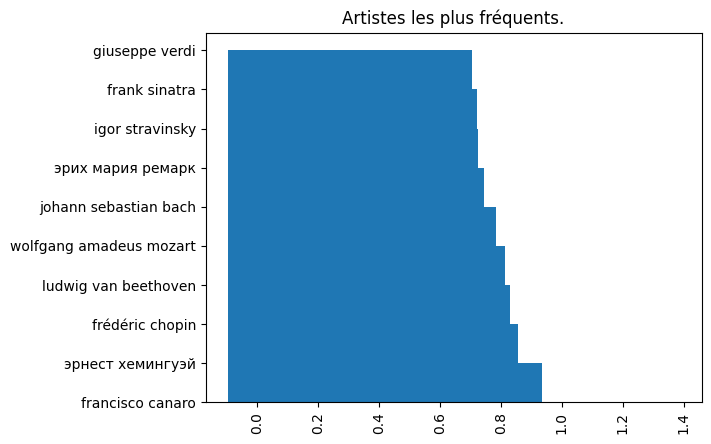

In [7]:
Artists_Dictionnary = {}

for Liste_Artistes in Data[:,artists]:
    Liste_Artistes = Liste_Artistes.replace("[", "").replace("]", "").replace("'", "").lower().split(", ")
    for Artiste in Liste_Artistes:
        if Artiste in Artists_Dictionnary:      # Si l'artiste est déjà dans le dictionnaire
            Artists_Dictionnary[Artiste] += 1   # On incrémente son compteur
        else:
            Artists_Dictionnary[Artiste] = 1    # Sinon on l'ajoute au dictionnaire avec un compteur à 1

Sorted_Artists_Dictionnary = sorted(Artists_Dictionnary.items(), key=lambda x: x[1], reverse=True)

Sum = 0
for i in range(len(Sorted_Artists_Dictionnary)):
    Sum += Sorted_Artists_Dictionnary[i][1]

for i in range(len(Sorted_Artists_Dictionnary)):
    Sorted_Artists_Dictionnary[i] = (Sorted_Artists_Dictionnary[i][0], (Sorted_Artists_Dictionnary[i][1] / Sum) * 100)

Sorted_Artists_Name = [Pair[0] for Pair in Sorted_Artists_Dictionnary]
Sorted_Artists_Count = [Pair[1] for Pair in Sorted_Artists_Dictionnary]

plt.bar(Sorted_Artists_Count[:10], Sorted_Artists_Name[:10])
plt.title("Artistes les plus fréquents.")
plt.xticks(rotation='vertical')
plt.savefig("./Images/Artistes les plus fréquents.svg")
plt.show()

Il n'y a pas grand chose à déduire, cependant on peut remarquer que les artistes les plus représentés sont les artistes qui ont le plus de musiques dans le dataset. On peut aussi remarquer que les artistes les plus représentés sont des artistes qui ont commencé leur carrière dans les années 60-70.

## 🔢 Variables quantitatives

### Variables quantitatives discrètes

#### 🕰️ Année

On ignore la variable `release_date` car elle est redondante avec la variable `year`. 

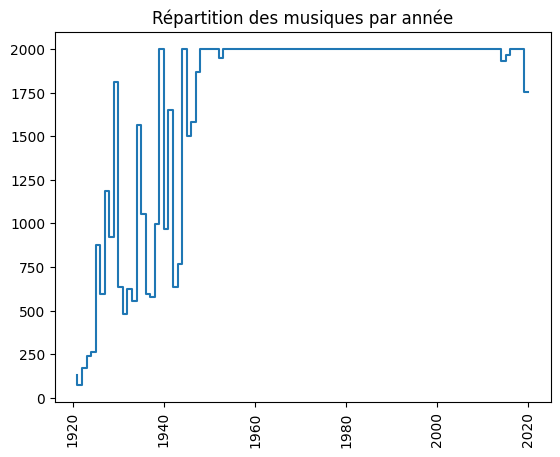

In [8]:
Release_Date_Year_Unique, Release_Date_Count = np.unique(Data[:, year], return_counts=True)

plt.step(Release_Date_Year_Unique, Release_Date_Count)
plt.title("Répartition des musiques par année")
plt.xticks(rotation='vertical')
plt.savefig("./Images/Répartition des musiques par année.svg")
plt.show()

On constate que les années sont représentées de manière uniforme dans ce jeu de données à partir de 1950 (2000 par année). Ce qui est logique afin d'avoir la représentation la plus objective possible. Le manque de musique avant 1950 est dû au fait que les musiques de cette époque ne sont pas assez représentées dans les plateformes de streaming (perte de données liée à la guerre ?).

#### 🅴 Explicite

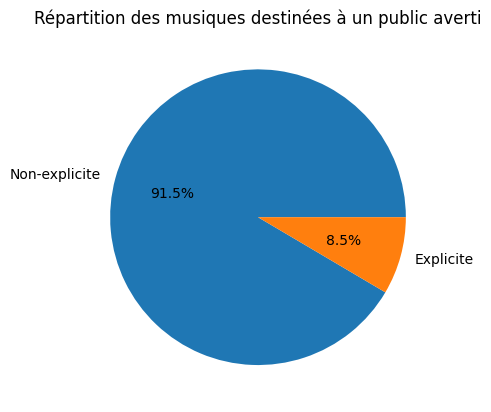

In [9]:
Explicit_Unique, Explicit_Count = np.unique(Data[:, explicit], return_counts=True)

Explicit_Count = (Explicit_Count / Data.shape[0]) * 100

plt.pie(Explicit_Count, labels=["Non-explicite", "Explicite"], autopct='%1.1f%%')
plt.title("Répartition des musiques destinées à un public averti")
plt.savefig("./Images/Répartition des musiques destinées à un public averti.svg")
plt.show()

On remarque que la majorité des musiques ne sont pas explicites.

### 🎼 Tonalité

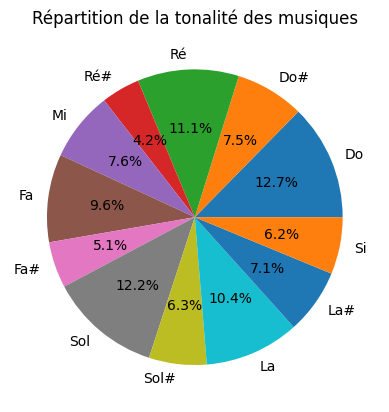

In [10]:
Key_Unique, Key_Count = np.unique(Data[:, key], return_counts=True)

plt.pie(Key_Count, labels=["Do", "Do#", "Ré", "Ré#", "Mi", "Fa", "Fa#", "Sol", "Sol#", "La", "La#", "Si"], autopct='%1.1f%%')
plt.title("Répartition de la tonalité des musiques")
plt.savefig("./Images/Répartition de la tonalité des musiques.svg")
plt.show()

### 📈 Variables quantitatives continues

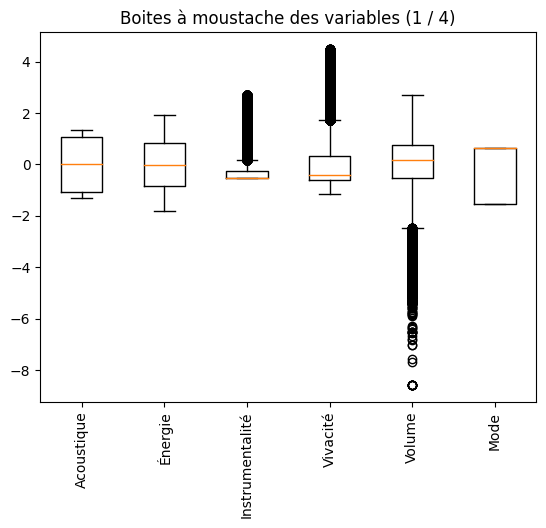

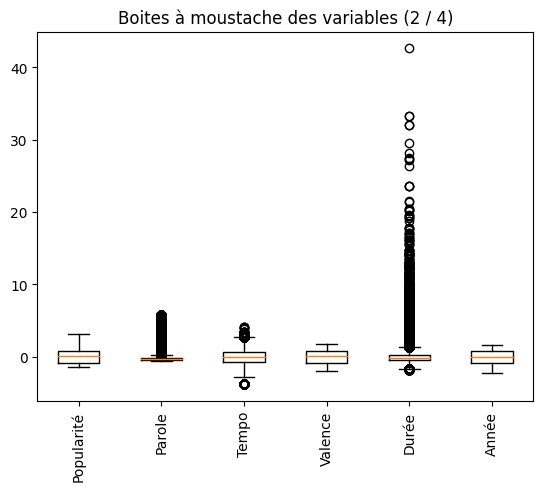

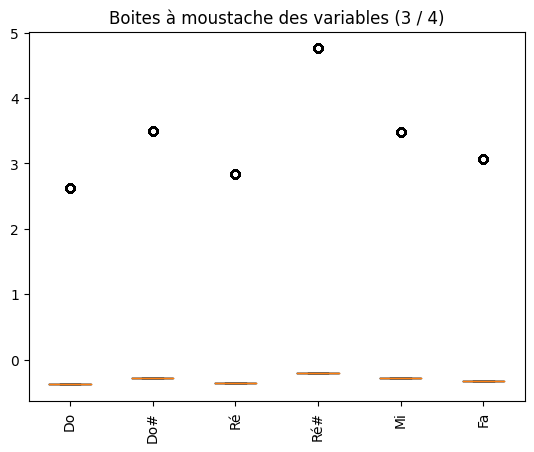

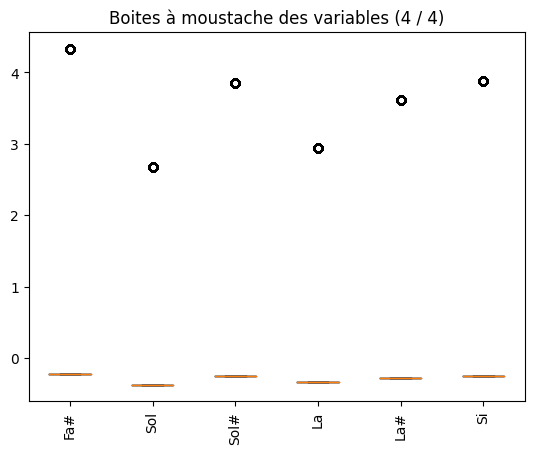

In [11]:
i = 0
while i < X.Variables():
    plt.boxplot(X.Scaled()[:,i:i+6])
    plt.xticks(np.arange(1, 7), X.Labels()[i:i+6], rotation='vertical')
    i = min(i + 6, X.Variables())
    plt.title(f"Boites à moustache des variables ({int(i/6)} / {int(X.Variables()/6)})")
    plt.show()


On se rend compte que la plupart des données d'instrumentalité, de vivacité et de paroles sont très basses, mais il existent tout de même un nombre important de valeurs supérieures au 3eme quartile. 

Le problème vient peut être du fait que les données ne sont pas normalisées. 

On remarque que des valeurs abberantes existent pour les variables vivacité, Paroles, et Valence. Il y en a également une quantité importante pour la variable énergie, supérieures au 3eme quartile. 

# 🔬 Analyse

## Analyse en Composantes Principales

On fait ensuite le calcul de la matrice de correlation.

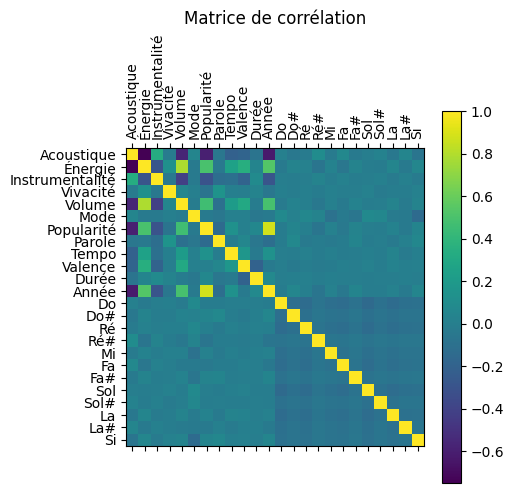

In [12]:
Correlation_Matrix = (X.Scaled().T @ X.Scaled()) / X.Observations()

plt.matshow(Correlation_Matrix)
plt.xticks(np.arange(X.Variables()), X.Labels(), rotation='vertical')
plt.yticks(np.arange(X.Variables()), X.Labels())
plt.colorbar()
plt.title("Matrice de corrélation")
plt.savefig("./Images/Matrice de corrélation.svg")
plt.show()

La matrice a bien une diagonale dominante, ce qui est normal car les variables sont indépendantes. On peut donc appliquer l'ACP.

On remarque par ailleurs que certaines variables semblent correlées entre elles :
- `acousticness` avec `energy`, `popularity` et `year`. En effet, il semblerait que plus une musique est acoustique, moins elle est énergique, moins elle est populaire et moins elle est récente.
- `popularity` avec `year`. En effet, il semblerait que moins une musique est récente, moins elle est populaire.

Text(0.5, 1.0, 'Pourcentage de variance expliquée par les composantes principales')

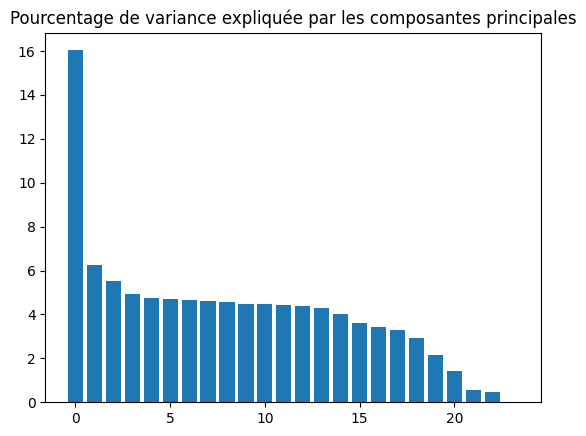

In [13]:
Eighenvalues, Eighenvectors = np.linalg.eigh(Correlation_Matrix)

Indexes = np.argsort(Eighenvalues)[::-1]
Eighenvalues = Eighenvalues[Indexes]
Eighenvectors = Eighenvectors[:,Indexes]

Eighenvalues_Percents =( Eighenvalues / np.sum(Eighenvalues)) *100

Eighenvalues_Percents_Cumsum = np.cumsum(Eighenvalues_Percents)
plt.bar(np.arange(X.Variables()), Eighenvalues_Percents)
plt.title("Pourcentage de variance expliquée par les composantes principales")

Cas pas idéal : il faut pre

## Régressions linéaires multiples

1. On définie ensuite une fonction qui se charge l'entrainement du modèle de régression linéaire multiple, ainsi que le calcul de certains indicateurs. Nous utilisons les formules suivantes :

- Regression linéaire : $\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n$ (résolution du système).
- Résidus : $e_i = y_i - \hat{y_i}$.
- Coefficient de détermination : $R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y_i})^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}$.
- Estimation non biaisée de la variance : $\hat{\sigma}^2 = \frac{\sum_{i=1}^{n} e_i^2}{n-p-1}$.

*Nous avons choisi d'utiliser `LinearRegression()` de `sklearn` pour limiter le code inutile.*

In [14]:
def Linear_Regression(X,Y, Return_R2 = False, Return_Residual_Error = False):
    L = LinearRegression()
    L.fit(X, Y)
    Residuals = Y - L.predict(X)
    
    if Return_R2 and Return_Residual_Error:
        n, p = X.shape
        s2 = np.sum(Residuals**2) / (n - p)
        return L, Residuals, L.score(X, Y), s2
    elif Return_R2:
        return L, Residuals, L.score(X, Y)
    elif Return_Residual_Error:
        n, p = X.shape
        s2 = np.sum(Residuals**2) / (n - p)
        return L, Residuals, s2
    else:
        return L, Residuals

Model, Residuals, R2 = Linear_Regression(X.Scaled(), Y.Scaled(), True, False)


3. On affiche ensuite les coefficients de la régression linéaire multiple.

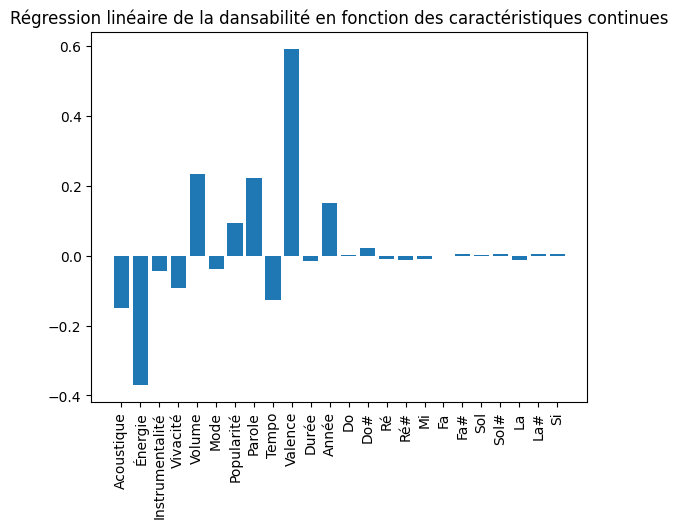

In [15]:
plt.bar(np.arange(X.Variables()), Model.coef_[0])
plt.title("Régression linéaire de la dansabilité en fonction des caractéristiques continues")
plt.xticks(np.arange(X.Variables()), X.Labels(), rotation='vertical')
plt.savefig("./Images/Régression linéaire de la dansabilité en fonction des caractéristiques continues.svg")
plt.show()

On se rend alors compte compte que les variables favorisant le plus à la danceabilité d'une musique sont :
- `valence` : La positivité de la musique
- `speechiness` : La quantité de paroles dans la musique
- `year` : L'année de sortie de la musique. Plus une musique est récente, plus elle est dansable. Cette variable cependant est à prendre avec des pincettes car bien que quantitatives discrète, ici elle est utilisé comme une variable quantitative continue. Il faudrait donc la transformer en variable qualitative.
- `popularity` : La popularité de la musique

On se rend également compte que les musiques en do dièse mineur sont les plus dansables. Bien que cela ne semble pas avoir un impact significatif sur la danceabilité d'une musique. Ce qui est cohérent avec les résultats de l'ACP et logique car la tonalité d'une musique est subjective.

Tandis que les variables qui défavorisent le plus la danceabilité d'une musique sont :

- `acousticness` : La quantité d'instruments acoustiques dans la musique
- `energy` : L'énergie de la musique
- `liveness` : La présence d'un public dans la musique


Les autres variables ne semblent pas contribuer de manière significative à la danceabilité d'une musique.

Ces résultats sont cohérents avec les résultats de l'ACP, mais également semblent aller vers le sens commun (excepté l'énergie de la musique, mais cette variable de la musique est subjective).

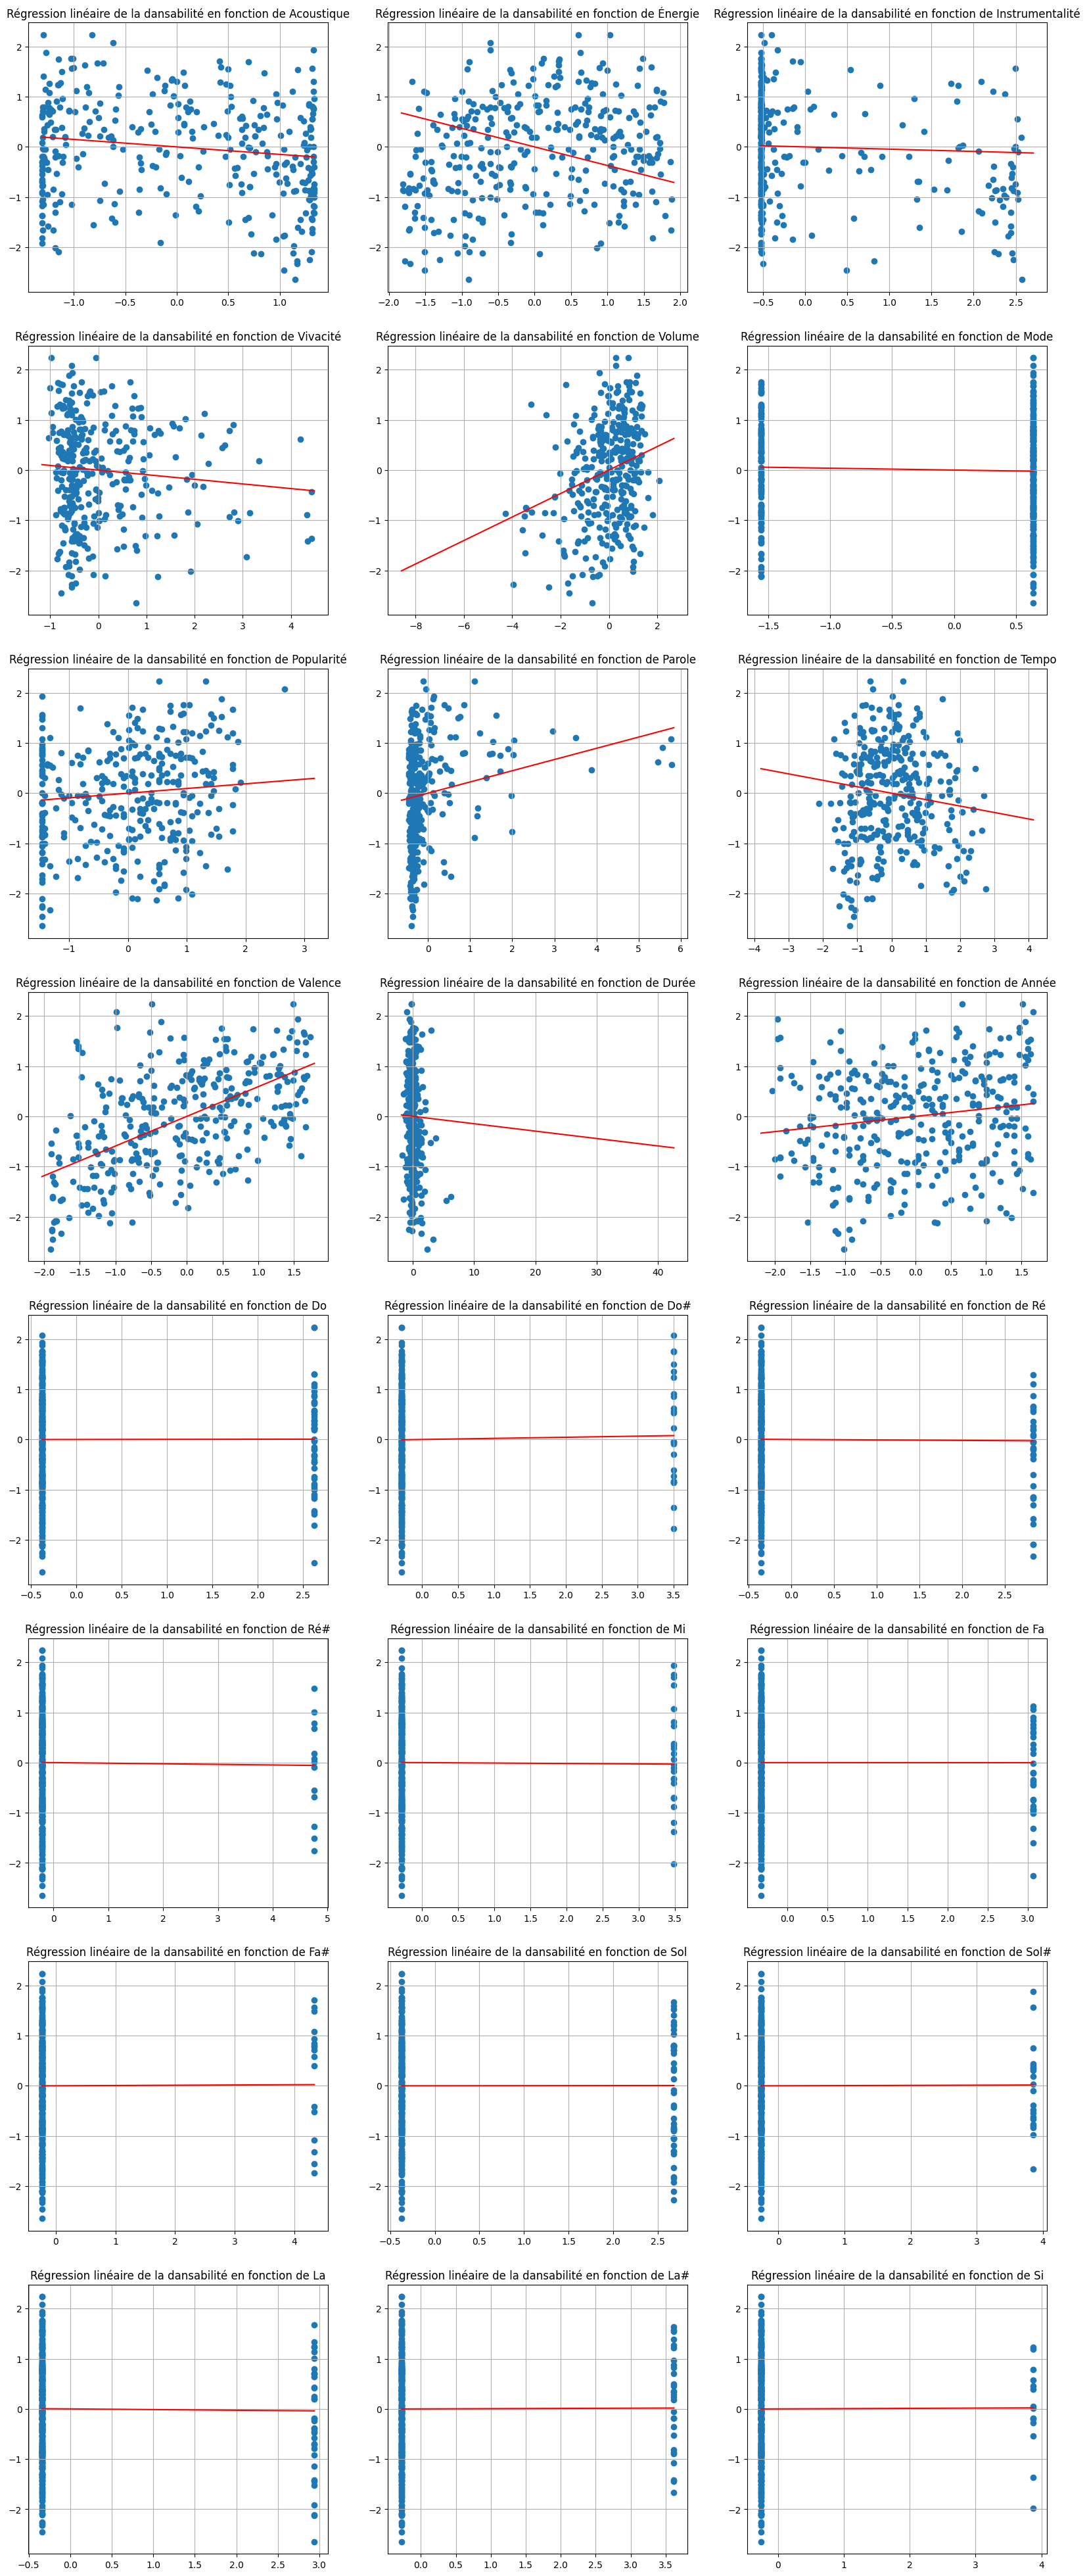

In [16]:
Figure = plt.figure(figsize=(20, 50))

for i in range(X.Variables()):
    # - Nuage de points (1 point tout les 500 pour éviter la surcharge)
    Subplot = Figure.add_subplot(int(X.Variables() / 3), 3, i + 1)
    Subplot.scatter(X.Scaled()[::500, i], Y.Scaled()[::500])
    # - Droite de régression
    Interval = np.linspace(np.min(X.Scaled()[:, i]), np.max(X.Scaled()[:, i]), 100)
    Subplot.plot(Interval, Model.coef_[0, i] * Interval, color='red')
    Subplot.set_title(f"Régression linéaire de la dansabilité en fonction de {X.Labels()[i]}")
    Subplot.grid()

Figure.savefig("./Images/Régression linéaire de la dansabilité en fonction des caractéristiques continues (avec outliers).svg")

#plt.savefig("./Images/Régression linéaire de la dansabilité en fonction des caractéristiques continues (avec outliers).svg")
plt.show()

# 👨‍⚕️ Diagnostique du modèle

Dans cette partie, nous allons faire le diagnostique du jeu de donnée afin d'améliorer le modèle. Car comme nous l'avons vu précédemment, le modèle est loin d'être parfait (R² trop élevé)

### Sélection de variables

1. Tout d'abord, nous allons nous intéresser au coefficients de détermination de chaque variable dans le modèle de régression linéaire multiple.

In [17]:
def Get_Cp_Mallows(n, pi, v, S2):
    return (n - pi) * v / S2 - n + 2 * pi

1. On implémente une fonction `Forward_Selection` qui effectue qui :
   1.  Il sélectionne itérativement les variables les plus importantes en évaluant l'ajout de chaque variable à un modèle existant en utilisant les mesures de R2 et de Cp. 
   2.  Le processus se poursuit jusqu'à ce que toutes les variables aient été évaluées et le modèle final est celui avec le Cp le plus bas. L'algorithme renvoie les variables sélectionnées, le R2 correspondant et le Cp associé au modèle final.

In [18]:
def Forward_Selection(X, Y):
    n, p = X.shape

    var_in = []
    var_out = [x for x in range(p)]
    R2_all_models = []
    Cp = []

    Selected_Variables = []

    _, _, s2_complet = Linear_Regression(X, Y, Return_Residual_Error=True)

    for i in range(p):
        s2_i = []
        R2_i = []

        for j in range(len(var_out)):
            liste_variables_courante = var_in + [var_out[j]]
                        
            _, _, R2_courant, s2_courant = Linear_Regression(X[:, liste_variables_courante], Y, Return_R2=True, Return_Residual_Error=True)

            s2_i.append(s2_courant)
            R2_i.append(R2_courant)

        # - Selection du meilleur modèle

        v = np.min(s2_i)
        ind = np.argmin(s2_i)
        R2_all_models.append(R2_i[ind])

        # - Ajout du meilleur modèle à la liste des modèles

        #pi = len(var_in) + 1
        pi = X[:, liste_variables_courante].shape[1] + 1

        #pi = len(liste_variables_courante)
        #pi = X_courant.shape[1]

        Cp.append(Get_Cp_Mallows(n, pi, v, s2_complet))

        var_in = var_in + [var_out[ind]]
        Selected_Variables.append(list(liste_variables_courante)) 
        var_out.remove(var_out[ind])

    Lowest_Cp = np.argmin(Cp)
    return Selected_Variables[Lowest_Cp], R2_all_models[Lowest_Cp], Cp[Lowest_Cp]

In [19]:
Reduction_Selected_Variables, R2, Cp = Forward_Selection(X.Scaled(), Y.Scaled())

print(f"Le meilleur modèle est obtenu avec les variables {Reduction_Selected_Variables} et a un R2 de {R2} et un Cp de {Cp}")

Le meilleur modèle est obtenu avec les variables [9, 11, 7, 8, 3, 2, 1, 4, 0, 6, 5, 13, 10, 21, 15, 14, 16, 17, 19, 23] et a un R2 de 0.48965083856434255 et un Cp de 17.781658190710004


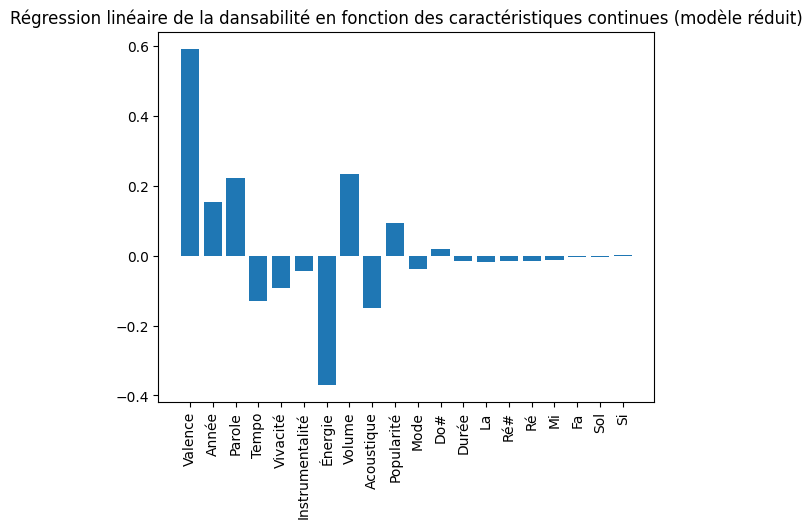

In [20]:
X_Reduced = Data_Class(X.Raw()[:, Reduction_Selected_Variables], [X.Labels()[i] for i in Reduction_Selected_Variables])

Model_Reduced, Residuals_Reduced, R2_Reduced = Linear_Regression(X_Reduced.Scaled(), Y.Scaled(), True)

plt.bar(np.arange(X_Reduced.Variables()), Model_Reduced.coef_[0])
plt.title("Régression linéaire de la dansabilité en fonction des caractéristiques continues (modèle réduit)")
plt.xticks(np.arange(X_Reduced.Variables()), X_Reduced.Labels(), rotation='vertical')
plt.savefig("./Images/Régression linéaire de la dansabilité en fonction des caractéristiques continues (modèle réduit).svg")
plt.show()

### Elimination des valeurs aberrantes

Notre première stratégie sera d'identifier les points aberrants, puis de les supprimer afin de voir si cela améliore le modèle.

1. Tout d'abord, on écrit une fonction qui permet de calculer les leviers et contribution de chaque point du jeu de données. On utilise les formules suivantes :

Pour le levier :

$$
H = X (X^\top X)^{-1}X^\top
$$

Les leviers se trouvent sur la diagonale de la matrice ($H_{ii}$).

Pour la contribution :

$$
  c_i = \frac{H_{ii}}{(1 - H_{ii})^2}\frac{\hat \varepsilon_i^2}{p s^2}
$$

In [21]:
def Linear_Regression_Metrics(X, Y):
    n, p = X.shape
    
    Model, Residuals = Linear_Regression(X,Y)
 
    Residuals = Residuals.T[0]  # Affreux bidouillage pour avoir un vecteur

    # - Calcul 
    s2 = np.sum(Residuals ** 2)/ (n - p - 1)

    # - Calcul des leviers
    H = X @ np.linalg.solve(X.T @ X, X.T)  
    h = np.diag(H)  # On ne garde que les éléments diagonaux
       
    # - Calcul des contributions
    c = h / ((1-h) ** 2) * (Residuals ** 2) / (p * s2)

    return h, c

2. Défini ensuite une autre fonction qui procède un calcul par blocks de 1000 points afin de ne pas surcharger la mémoire vive.

In [22]:
# - Calcul des coefficients de régression et des statistiques associées pour chaque bloc
def Linear_Regression_Metrics_By_Block(X,Y, Block_Size = 1000):
    n, p = X.shape

    Number_Blocks = int(np.ceil(n / Block_Size))    # On calcule le nombre de blocs et on arrondit à l'entier supérieur

    # - Initialisation des listes qui vont contenir les résultats des régressions des différents blocs
    h = np.zeros(n)
    c = np.zeros(n)

    for i in range(Number_Blocks):
        Start_Index = i * Block_Size 
        End_Index = min((i+1) * Block_Size, n)

        h_Block, c_Block = Linear_Regression_Metrics(X[Start_Index:End_Index], Y[Start_Index:End_Index])

        h[Start_Index : End_Index] = h_Block
        c[Start_Index : End_Index] = c_Block

    # - On refait une régression avec toutes les données
    _, Residuals, R2 = Linear_Regression(X,Y, Return_R2 = True)

    s2 = np.sum(Residuals ** 2)/ (n - p - 1)

    return Residuals, R2, s2, h, c

3. Une fois la fonction définie, on l'applique sur le jeu de données.

In [23]:
Residuals, R2, s2, Levers, Contributions = Linear_Regression_Metrics_By_Block(X_Reduced.Scaled(), Y.Scaled())

KeyboardInterrupt: 

4. On calculs les seuils pour lequel on considère qu'un point est aberrant. On prends les seuils suivants :
   - Levier : 2 * (Nombre_De_Variables + 1) / Nombre_De_Points
   - Contribution :
   - Résidus :

*On effectue les calculs des seuils de manière anticipé afin d'accélérer l'éxecution de `np.where(...)`.*

In [ ]:
Contributions_Threshold = np.quantile(Contributions, 0.80)

print(f"Le seuil de contribution est de : {Contributions_Threshold}")

Le seuil de contribution est de : 0.0015426430313901336


5. On cherche ensuite les points qui sont aberrants selon ces seuils, puis on les supprime du jeu de données.

In [ ]:
#Levers_Outliers_Indexes = np.where(Levers > Levers_Threshold)[0]
Contributions_Outliers_Indexes = np.where(Contributions > Contributions_Threshold)[0]

print(f"Le nombre de valeurs aberrantes trouvés est de : {len(Contributions_Outliers_Indexes)} ({len(Contributions_Outliers_Indexes) / Y.Observations() * 100:.2f}% des données).")

# - Suppression des valeurs aberrantes
X_Cleaned = Data_Class(np.delete(X_Reduced.Raw(), Contributions_Outliers_Indexes, axis=0), X_Reduced.Labels())
Y_Cleaned = Data_Class(np.delete(Y.Raw(), Contributions_Outliers_Indexes, axis=0), Y.Labels())

Le nombre de valeurs aberrantes trouvés est de : 33982 (20.00% des données).


6. A partir du nouveau jeu de données, on refait une régression linéaire multiple.

Le R2 de la régression linéaire avec nettoyage est de 0.6548116850433605.
Le R2 de la régression linéaire sans nettoyage est de 0.4896395231668256.


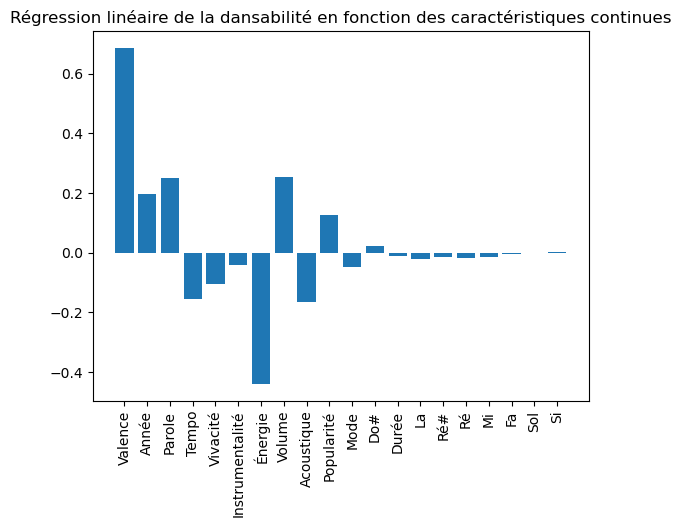

In [ ]:
Model_Cleaned, Residuals_Cleaned, R2_Cleaned = Linear_Regression(X_Cleaned.Scaled(), Y_Cleaned.Scaled(), True)

print(f"Le R2 de la régression linéaire avec nettoyage est de {R2_Cleaned}.")
print(f"Le R2 de la régression linéaire sans nettoyage est de {R2}.")

plt.bar(np.arange(X_Cleaned.Variables()), Model_Cleaned.coef_[0])
plt.title("Régression linéaire de la dansabilité en fonction des caractéristiques continues")
plt.xticks(np.arange(X_Cleaned.Variables()), X_Cleaned.Labels(), rotation='vertical')
plt.savefig("./Images/Régression linéaire de la dansabilité en fonction des caractéristiques continues.svg")
plt.show()

## ✅ Test statistiques 


### Explicite et dansabilité 

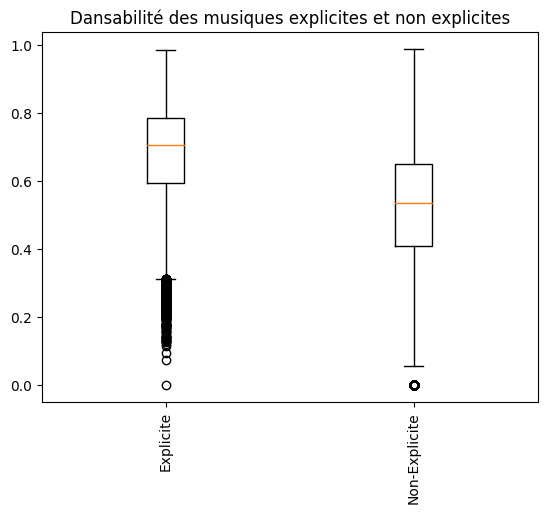

In [51]:
#Séparation de la dansibilité des musiques explicites et celle des musiques non-explicites 
dansabilité_explicite = Data[Data[:,5] == True, 2]
dansabilité_non_explicite = Data[Data[:,5] == False, 2]
Boxplot_Data = [dansabilité_explicite,dansabilité_non_explicite]

plt.boxplot(Boxplot_Data)
plt.title("Dansabilité des musiques explicites et non explicites")
plt.xticks([1, 2], ["Explicite","Non-Explicite"], rotation='vertical')
plt.savefig("./Images/Boîte à moustaches de la dansabilité des musiques explicites et non-explicites.svg")
plt.show()

La médiane de dansabilité des musiques explicites est plus élevée que celle des musiques non-explicites. On peut donc formuler l'hypothèse que les musiques explicites sont plus dansables que les musiques non-explicites. Pour vérifier cette hypothèse, non effectuons un test de Student : n>30, variables indépendantes

In [58]:
stat_fisher, p_value = stats.f_oneway(dansabilité_explicite, dansabilité_non_explicite)
print("Statistique de Levene :", stat_fisher)
print("P-value :", p_value)


Statistique de Levene : 10559.345881666097
P-value : 0.0


In [57]:
#Calcul des variances 
variance_explicite = np.var(dansabilité_explicite)
variance_non_explicite = np.var(dansabilité_non_explicite)
print(variance_explicite)
print(variance_non_explicite)

statistique, p_value = stats.bartlett(dansabilité_explicite,dansabilité_non_explicite)

# Afficher les résultats
print("Statistique de Bartlett :", statistique)
print("P-value :", p_value)

moyenne_dansabilité_explicite = np.mean (dansabilité_explicite)
moyenne_dansabiité_non_explicite = np.mean(dansabilité_non_explicite)
variance = 0.02
t = (moyenne_dansabilité_explicite - moyenne_dansabiité_non_explicite) / np.sqrt(variance * (1/len(dansabilité_explicite) + 1/len(dansabilité_non_explicite)))
p_value = 2 * (1-stats.norm.cdf(abs(t),0,1))
print(p_value)

0.02396199097155869
0.029409242264621917
Statistique de Bartlett : 261.47578287966405
P-value : 8.181522902293851e-59
0.0


### Explicite et popularité

### Explicite et année

Nous allons étudier la relation entre les variables "explicite" et année. L'hypothèse H0 est que ces dernières sont indépendantes, la seconde est donc qu'elles sont liées. Pour ce faire, nous effectuons un test du chi2.

In [50]:
#Test du chi2
from sklearn.metrics.cluster import contingency_matrix
from scipy.stats import chi2_contingency
#Creation du vecteur variable "décennie" (on regroupe les musiques par décénnie)
data_decennie = [(annee // 10) * 10 for annee in Data[:,year]]


#Création de la table de contingence
tableau_Contingence = contingency_matrix(data_decennie,Data[:,explicit])
print(tableau_Contingence)

p_col = np.sum(tableau_Contingence, axis = 0)
p_ligne = np.sum(tableau_Contingence, axis = 1)
tableau_théorique = np.outer(p_ligne, p_col) / np.sum(tableau_Contingence)
print(tableau_théorique)
distance = np.sum((tableau_théorique-tableau_Contingence)**2 / tableau_théorique)
print(distance)
degre_liberte = (len(p_ligne)-1)*(len(p_col)-1)
print(degre_liberte)
#(p_value = 1-stats.chi2.cdf(distance,degre_liberte))
p_value = stats.chi2.sf(distance,degre_liberte)
print(p_value)

[[ 3778   668]
 [ 8595   294]
 [14029   939]
 [19778   172]
 [19988    12]
 [19936    64]
 [19513   487]
 [17627  2373]
 [17146  2854]
 [14209  5691]
 [  891   865]]
[[ 4068.69877405   377.30122595]
 [ 8134.65213732   754.34786268]
 [13697.76951192  1270.23048808]
 [18256.98167843  1693.01832157]
 [18302.73852474  1697.26147526]
 [18302.73852474  1697.26147526]
 [18302.73852474  1697.26147526]
 [18302.73852474  1697.26147526]
 [18302.73852474  1697.26147526]
 [18211.22483212  1688.77516788]
 [ 1606.98044247   149.01955753]]
21907.157796372452
10
0.0


# 🛠️ Application

Nous allons maintenant essayer d'appliquer notre modèle à un cas concret. Cela n'a pas pour but d'être une application réelle, car spotify fourni déjà la `dansabilité` d'une musique, mais cela nous permettra plutôt de tester l'efficacité de notre modèle.

*Nous avons du au préalable créer une "application" sur le site de [l'API de Spotify](https://developer.spotify.com/) afin d'obtenir un `Client_ID` et un `Client_Secret`.*

**Merci de ne surtout pas partager ces informations, car elles sont reliées à un de nos compte Spotify. Ces accès seront révoqués une fois les notes rendues de M8 rendues.**

1. On commence par définir des variables d'envirronement qui permettront de définir les paramètres de notre application :

- `Client_ID` : L'identifiant de l'application spotify.
- `Client_Secret` : Le mot de passe de l'application spotify.
- `Enable_Example` : Si `True`, les musiques de la liste `Examples` seront automatiquement testées avec le modèle.
- `SpotiPy_Client` : L'objet `SpotiPy` qui permettra de se connecter à l'API de Spotify.

In [ ]:
Client_ID = "a757131d2d114c91b4a01f4845441f89"     
Client_Secret = "05a4f6e6955646d7865df73e0c89de2d"

Enable_Examples = True  # ! : Désactiver si nécessaire (pour éviter de faire des requêtes qui prennent du temps).

Examples = ["Vernini Vernana Téo Lavabo",
            "Give me everything Pitbull",
            "Les p'tites femmes de Pigalle Serge Lama",
            "Born to be alive Patrick Hernandez",
            "Starships Nicki Minaj",
            "Moulaga Heuss L'enfoiré",
            "L'apologie Matmatah",
            "Sunday bloody sunday U2",
            "Rasputin Boney M",
            "Last Friday Night Katy Perry",
            "S&M Rihanna",
            "Rapsodie Hongroise n°2 Liszt",
            "All the Time Don Diablo",
            "Bohemian Rhapsody Queen",
            "Une belle journée Mylène Farmer",
            "Enjoy the silence Depeche Mode",
            "Riptide Vance Joy", 
            "Girl's Club Marc Rebillet"]

SpotiPy_Client = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=Client_ID, client_secret=Client_Secret))

2. On définit ensuite une fonction qui permettra à partir d'une recherche utilisateur (nom de la musique, nom de l'artiste, nom de l'album) de récupérer les informations des 10 premières musiques trouvées :

- Le nom de la musique
- Une liste des artistes
- L'identifiant de la musique

In [ ]:
def Search_Track(Client, Name):
    Raw_Results = Client.search(q=Name, limit=10)

    Results = []

    # - Affichage des résultats de la recherche
    for i, Track in enumerate(Raw_Results['tracks']['items']):
        Artists = []
        for Artist in Track['artists']:
            Artists.append(Artist['name'])     

        Results.append([    Track['name'],
                            Artists,
                            Track['id']])
    return Results

3. On définit une fonction qui permettra de récupérer les informations d'une musique nécéssaire au modèle, à partir de son identifiant. Les informations sont formatés pour être utilisé directement par le modèle.

In [ ]:
def Get_Track_Data(Client, Track_Identifier):
    Track = Client.track(Track_Identifier)
    Audio_Features = Client.audio_features(Track_Identifier)[0]
    Audio_Analysis = Client.audio_analysis(Track_Identifier)

    Track_Data_Raw = np.array([
            Audio_Features['acousticness'],
            Audio_Features['energy'],
            Audio_Features['instrumentalness'],
            Audio_Features['liveness'],
            Audio_Analysis["sections"][0]["loudness"],
            Audio_Analysis["sections"][0]["mode"],
            Track['popularity'],
            Audio_Features['speechiness'],
            Audio_Analysis["sections"][0]["tempo"],
            Audio_Features['valence'],
            Audio_Features["duration_ms"],
            int(Track["album"]["release_date"].split("-")[0]),
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0
        ], dtype=np.float64)

    Track_Data_Raw = np.array([Track_Data_Raw[Reduction_Selected_Variables]])

    for i, Index in enumerate(Reduction_Selected_Variables):
        if Index == (Audio_Analysis["track"]["key"] + 12):
            Track_Data_Raw[0][i] = 1.0

    return Track_Data_Raw


4. On définit également une fonction qui permettra de récupérer la `dansabilité` à partir de l'identifiant d'une musique.

In [ ]:
def Get_Spotify_Danceability(Client, Track_Identifier):
    Audio_Features = Client.audio_features(Track_Identifier)[0]
    return Audio_Features['danceability']

5. On définit enfin une fonction qui effectura la prédictions de la `dansabilité` d'une musique à partir de son identifiant.

In [ ]:
def Predict_Danceability(Track_Data):
    Track_Data_Scaled = (Track_Data - X_Cleaned.Mean()) / X_Cleaned.Standard_Deviation()  # On normalise les données

    Result_Scaled = Model_Cleaned.predict(Track_Data_Scaled)[0][0]    # On prédit la dansabilité

    Result = Result_Scaled * Y_Cleaned.Standard_Deviation() + Y_Cleaned.Mean()   # On inverse la normalisation
    
    return Result[0]

6. On a enfin, le code qui s'occupe d'exploiter les fonctions précédentes afin de prédire la `dansabilité` d'une musique et la comparer à la `dansabilité` récupérée par l'API de Spotify.

In [ ]:
Deltas = []

if Enable_Examples:
    # - On parcourt les exemples
    for Example in Examples:
        try:    # On essaie de se connecter à l'API Spotify
            Tracks = Search_Track(SpotiPy_Client, Example)
            Track_Data = Get_Track_Data(SpotiPy_Client, Tracks[0][2]) 
        except: # Si on n'y arrive pas, on affiche un message d'erreur et on passe à l'exemple suivant
            print(f"Impossible de se connecter à l'API Spotify pour la musique \"{Example}\". Vérifiez votre connexion internet et réessayez.")
            continue

        # - On affiche les résultats
        # - - Transformation de la liste des artistes en chaîne de caractères
        Artists_String = ""
        for i, Artist in enumerate(Tracks[0][1]):
            if i != 0:
                Artists_String += ", "
            Artists_String += Artist

        print(f"La dancabilité de la musique \"{Tracks[0][0]}\" de {Artists_String} :")

        try:    # On essaie de se connecter à l'API Spotify
            Spotify_Danceability = round(Get_Spotify_Danceability(SpotiPy_Client, Tracks[0][2]) * 100, 2)  # On récupère la dansabilité sur Spotify et on l'arrondit à 4 chiffres significatifs
            Predicted_Danceability = round(Predict_Danceability(Track_Data) * 100, 2)   # On prédit la dansabilité et on l'arrondit à 4 chiffres significatifs
            Delta = round(abs(Spotify_Danceability - Predicted_Danceability), 2)    # On calcule la différence entre la dansabilité prédite et la dansabilité sur Spotify et on l'arrondit à 4 chiffres significatifs
            Deltas.append(Delta)
            print(f"\tPrédite : {Predicted_Danceability} % - Spotify : {Spotify_Danceability} % - Delta : {Delta} %")
        except: # Si on n'y arrive pas, on affiche un message d'erreur et on affiche la prédiction sans comparer.
            print(f"\tImpossible de se connecter à l'API Spotify pour la musique \"{Example}\". Vérifiez votre connexion internet et réessayez.")
            Predicted_Danceability = round(Predict_Danceability(Track_Data) * 100, 2)  # On prédit la dansabilité et on l'arrondit à 4 chiffres significatifs
            print(f"\tPrédite : {Predicted_Danceability} %")


La dancabilité de la musique "Vernini Vernana" de Téo Lavabo, Manon Lavabo :
	Prédite : 65.96 % - Spotify : 78.3 % - Delta : 12.34 %
La dancabilité de la musique "Give Me Everything (feat. Ne-Yo, Afrojack & Nayer)" de Pitbull, Ne-Yo, AFROJACK, Nayer :
	Prédite : 57.54 % - Spotify : 67.1 % - Delta : 9.56 %
La dancabilité de la musique "Les p'tites femmes de Pigalle" de Serge Lama :
	Prédite : 57.0 % - Spotify : 59.9 % - Delta : 2.9 %
La dancabilité de la musique "Born to Be Alive - The Original" de Patrick Hernandez :
	Prédite : 62.08 % - Spotify : 70.4 % - Delta : 8.32 %
La dancabilité de la musique "Starships" de Nicki Minaj :
	Prédite : 66.41 % - Spotify : 74.7 % - Delta : 8.29 %
La dancabilité de la musique "Moulaga" de Heuss L'enfoiré, Jul :
	Prédite : 60.28 % - Spotify : 71.0 % - Delta : 10.72 %
La dancabilité de la musique "L'apologie" de Matmatah :
	Prédite : 67.88 % - Spotify : 76.9 % - Delta : 9.02 %
La dancabilité de la musique "Sunday Bloody Sunday - Remastered 2008" de U2 :

7. On affiche les erreurs de prédictions dans une boite à moustache.

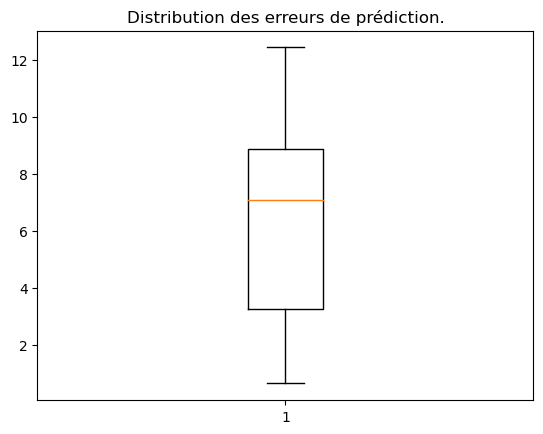

In [ ]:
plt.boxplot(Deltas)
plt.title("Distribution des erreurs de prédiction.")
plt.show()

Les différences entre les deux `dansabilite` peuvent être dues à plusieurs facteurs :
- Le jeu de données utilisé n'est pas forcément à jour, dans le sens où spotify a peut être modifié sa manière de calculer la `dansabilite` d'une musique entre temps.
- Le manque de certaines variables dans le jeu de données, qui sont pourtant utilisées par l'API de Spotify pour calculer la `dansabilite` d'une musique.